# SYDE 750: Course Project
## Research Notebook 
Start date: March 19, 2020

# I
## Objective


Explore learning under conflicting inputs (interfering)

# II 
# Background

Learning in simulated biological systems may have many parallels to language acquisition. In language, both positive and negative evidence are used to formulate grammar rules. Grammar, generally, includes syntax and semantics. 

### Language acquisition
Learning a language includes only true statements (when learning from native speakers). In Eliasmith's 2017 work, they use neural networks to draw inferences, using the input sentences as positive evidence, but did not consider the richness of information when also including implicit negative evidence. 

Next steps: When the model is trained on true and false statements, its behaviour with interfering and contradicting information can be quite challenging. 

Learning in the presence of inhibitory connections 
- What is the role of such connections
- What are the limitations without having those connections 

### Simulations 
- Can I infer wrong sentences from real sentences? 
- This would "prove" understanding

## Blouw 2018
- Use ensembles to represent individual words (word2vec embeddings) for leaf nodes

# Implementation

In [702]:
import numpy as np
import nengo
import nengo_spa as spa
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the default color cycle
# Colors 
cRang = np.linspace(0,1,10)
rgba = [mpl.cm.get_cmap('viridis')(i) for i in cRang]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=rgba) 

rng = np.random.RandomState(7)

### Generate random unitary vectors


In [802]:
#parameters
dims = 64
n_items = 10
all_pairs = spa.Vocabulary(dimensions=dims, pointer_gen=rng, max_similarity=0.3)

items = np.arange(n_items)+1
list_A = ['A' + str(i) for i in items]
list_B = ['B' + str(i) for i in items]
list_C = ['C' + str(i) for i in items]
list_D = ['D' + str(i) for i in items]

list_AU = [i + '.normalized()' for i in list_A]
list_BU = [i + '.normalized()' for i in list_B]
list_CU = [i + '.normalized()' for i in list_C]
list_DU = [i + '.normalized()' for i in list_D]

#generate pairs
A_B_short = [i[0]+ i[1] for i in list(zip(*[list_A,list_B]))]
C_D_short = [i[0]+ i[1] for i in list(zip(*[list_C,list_D]))]
C_B_short = [i[0]+ i[1] for i in list(zip(*[list_C,list_B]))]
A_D_short = [i[0]+ i[1] for i in list(zip(*[list_A,list_D]))]

A_B = [i[0]+ i[1] + ' = ' + i[0] + '*' + i[1] for i in list(zip(*[list_A,list_B]))]
C_D = [i[0]+ i[1] + ' = ' + i[0] + '*' + i[1] for i in list(zip(*[list_C,list_D]))]
C_B = [i[0]+ i[1] + ' = ' + i[0] + '*' + i[1] for i in list(zip(*[list_C,list_B]))]
A_D = [i[0]+ i[1] + ' = ' + i[0] + '*' + i[1] for i in list(zip(*[list_A,list_D]))]

A_BU = [i + '.normalized()' for i in A_B]
C_DU = [i + '.normalized()' for i in C_D]
C_BU = [i + '.normalized()' for i in C_B]
A_DU = [i + '.normalized()' for i in A_D]


all_pairs.populate(';'.join(list_AU+
                        list_BU+
                        list_CU+
                        list_DU+
                        A_BU+
                        C_DU+
                        C_BU+
                        A_DU))


# Competitive Interference with SPA 
- When two symbols are convolved with ~cue present in both symbols, output is a linear combination of the other two. 

In [397]:
model = spa.Network()

with model:
    cue = spa.Transcode('B1',output_vocab=all_pairs)
    objA = spa.Transcode('A1B1',output_vocab=all_pairs)
    
    out = spa.State(all_pairs)
    
    (spa.sym.A1B1 + spa.sym.C1B1) * ~cue >> out
    
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)
    
    p_out = nengo.Probe(out.output)
    
    
    
with nengo.Simulator(model) as sim:
    sim.run(3.)
    

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

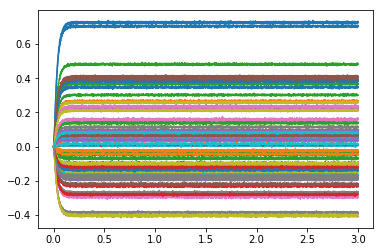

In [398]:
import matplotlib.pyplot as plt
simT = spa.similarity(sim.data[p_out], all_pairs)
plt.plot(sim.trange(), simT)
plt.show()

### Similarity Ranking 

In [835]:
def testAcc(probe,vocab,exp_response):
    simT = spa.similarity(sim.data[probe], vocab)
    testList = []
    times = [5.4,5.9,6.4,6.9,7.4,7.9,8.4,8.9,9.4,9.9] #10 total
    correct = 0
    for i in range(0,len(times)):
        testList.append(
            list(vocab.keys())[np.argsort(-simT[int(times[i]*1000):][0], kind='quicksort')[0]])
        if (testList[i] == exp_response[i]): correct+=1
    return correct

In [833]:
times[i]*1000

5400.0

## Learning: Phase 1

In [803]:
stimuli = all_pairs.create_subset(list_A+list_C)
response =  all_pairs.create_subset(list_B+list_D)
AB_pairs = all_pairs.create_subset(A_B_short)
n_keys = len(list(stimuli.keys()))
keys = np.zeros([n_keys,dims])
vals = np.zeros([n_keys,dims])

keynames = list_A+list_C
valnames = list_B+list_D
# makes array of keys from pointers 
for i in range(0,len(list(stimuli.keys()))):
    keys[i] = stimuli[keynames[i]].v
    vals[i] = response[valnames[i]].v

In [804]:
intercept = (np.dot(keys, keys.T) - np.eye(n_keys)).flatten().max()

In [639]:
def cycle_symsv(vocab,labels,period,dt=0.001):
    
    n = len(labels)
    
    """Cycles through the symbols"""
    i_every = int(round(period / dt))
    if i_every != period / dt:
        raise ValueError("dt (%s) does not divide period (%s)" % (dt, period))

    def f(t):
        i = int(round((t - dt) / dt))  # t starts at dt
        k = int(i/i_every) % n_items
        return vocab[labels[k]].v

    return f

In [638]:
def cycle_syms(vocab,labels,period,dt=0.001):
    
    n = len(labels)
    
    """Cycles through the symbols"""
    i_every = int(round(period / dt))
    if i_every != period / dt:
        raise ValueError("dt (%s) does not divide period (%s)" % (dt, period))

    def f(t):
        i = int(round((t - dt) / dt))  # t starts at dt
        k = int(i/i_every) % n_items
        return vocab[labels[k]]

    return f

In [805]:
# Phase 1: Learn A paired with B
from nengo.networks import CircularConvolution

dt = 0.001
period = 0.5
T = period * n_keys 
n_neuronsIN = 100*n_keys
n_neurons = 400


model = spa.Network()

with model:
    ground_a = spa.WTAAssocMem(
        threshold=0.3,
        input_vocab=all_pairs,
        mapping=all_pairs.keys(),
        function=lambda x: x > 0.)
    
    #phase 1 is training on pair one, phase 2 is training on pair two
    #phase -1 implies recall task (no learning)
    #learning
    learning = nengo.Node(output=lambda t: -int(t >= T / 2))# 1,2 or -1
    
    memorize = nengo.Node(output=lambda t: -int(t <= T / 2))
    
    stim = nengo.Node(cycle_symsv(stimuli,list_A,period,dt))
    r_in = nengo.Node(cycle_symsv(response,list_B,period,dt))
    
    #ground truth
    new_pair = nengo.Node(cycle_symsv(all_pairs,A_B_short,period,dt))
    
    map_ens = nengo.Ensemble(
        n_neuronsIN, dims, intercepts=[intercept] * n_neuronsIN)
    
    err_ens = nengo.Ensemble(n_neuronsIN,dims)
    
    map_result = nengo.Ensemble(n_neuronsIN,dims)
    
    state_ens = nengo.Ensemble(n_neuronsIN,dims)
    
    
    #perform unbinding
    cconv = CircularConvolution(n_neurons, dims, invert_b = True)
    state_out = nengo.Connection(state_ens,cconv.input_a)
    nengo.Connection(stim,cconv.input_b)
    
    #feedback
    nengo.Connection(state_ens,state_ens, transform=1, synapse=0.02)
    
    r_out = spa.State(all_pairs)
    
    # Learn the encoders/keys
    voja = nengo.Voja(learning_rate=0.1, post_synapse=None)
    
    map_in = nengo.Connection(
                    stim, map_ens, synapse=0, learning_rule_type=voja)
    
    nengo.Connection(learning, map_in.learning_rule)
    
    # Learn the decoders/values, initialized to a null function
    map_out = nengo.Connection(
        map_ens,
        map_result,
        learning_rule_type=nengo.PES(0.04),
        function=lambda x: np.zeros(dims))
    nengo.Connection(
        learning, err_ens.neurons, transform=[[10.0]] * n_neuronsIN, synapse=0)
    
    state_in=nengo.Connection(
        map_result, 
        state_ens,
        synapse=0)
    
    #inhibit any inputs to state_ens during learning phase
    nengo.Connection(
        memorize,
        state_ens.neurons,
        transform=[[-10.0]] * n_neuronsIN,synapse=0)

    # Calculate the error and use it to drive the PES rule
    nengo.Connection(new_pair, err_ens, transform=-1, synapse=0)
    nengo.Connection(map_result, err_ens, synapse=0)
    nengo.Connection(state_ens, err_ens, transform=-1, synapse=0)
    nengo.Connection(err_ens, map_out.learning_rule)
    
    
    
    
    #probes
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)
    
    # Setup probes
    p_keys = nengo.Probe(stim)
    p_rin = nengo.Probe(r_in)
    p_out = nengo.Probe(cconv.output)
    p_rout1 = nengo.Probe(state_in)
    p_rout2 = nengo.Probe(state_out)
    p_ground = nengo.Probe(new_pair)
    p_learning = nengo.Probe(learning)
    p_min = nengo.Probe(map_in)
    p_mout = nengo.Probe(map_out)    
    
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T)
t = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

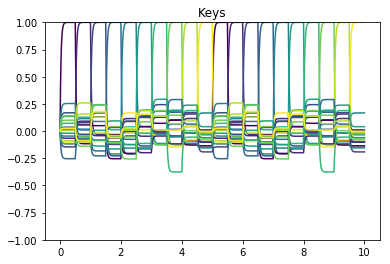

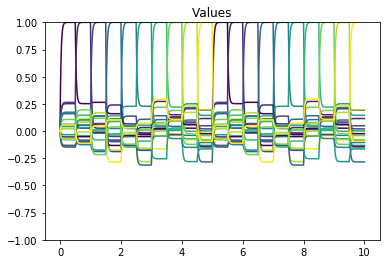

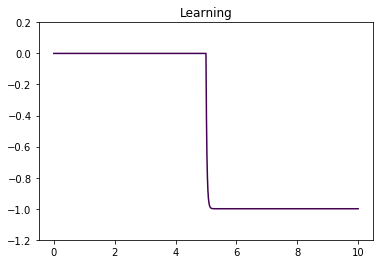

In [806]:
plt.figure()
plt.title("Keys")
plt.plot(t, spa.similarity(sim.data[p_keys], stimuli))
plt.ylim(-1, 1)

plt.figure()
plt.title("Values")
plt.plot(t, spa.similarity(sim.data[p_rin], response))
plt.ylim(-1, 1)

plt.figure()
plt.title("Learning")
plt.plot(t, sim.data[p_learning])
plt.ylim(-1.2, 0.2);

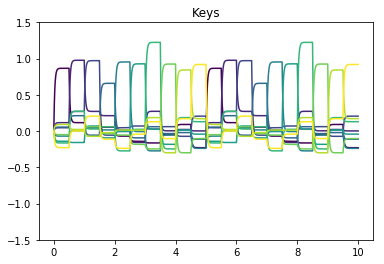

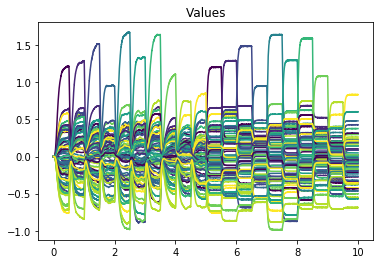

In [807]:
plt.figure()
plt.title("Keys")
plt.plot(t, spa.similarity(sim.data[p_ground], AB_pairs))
plt.ylim(-1.5, 1.5)

plt.figure()
plt.title("Values")
plt.plot(t, spa.similarity(sim.data[p_mout], all_pairs))
plt.show()

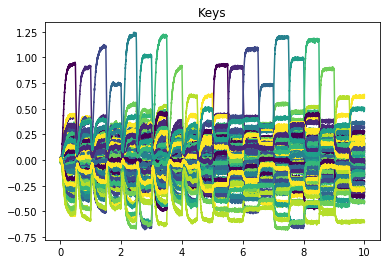

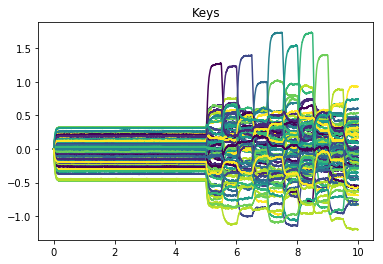

In [808]:
plt.figure()
plt.title("Keys")
plt.plot(t, spa.similarity(sim.data[p_rout1], all_pairs))
#plt.ylim(-1, 1)

plt.figure()
plt.title("Keys")
plt.plot(t, spa.similarity(sim.data[p_rout2], all_pairs))
#plt.ylim(-1, 1)
plt.show()

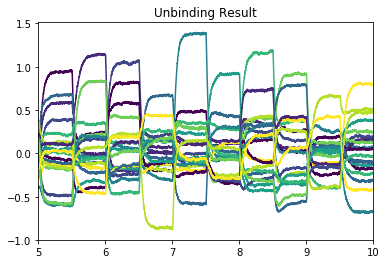

In [846]:
plt.figure()
plt.title("Unbinding Result")
plt.plot(t, spa.similarity(sim.data[p_out], response))
plt.xlim(5, 10)
plt.show()

In [837]:
simT = spa.similarity(sim.data[p_out], response)
testAcc(p_out,response,list_B)

10

In [805]:
# Phase 2: Learn A paired with B
from nengo.networks import CircularConvolution

dt = 0.001
period = 0.5
T = period * n_keys 
n_neuronsIN = 100*n_keys
n_neurons = 400


model = spa.Network()

with model:
    ground_a = spa.WTAAssocMem(
        threshold=0.3,
        input_vocab=all_pairs,
        mapping=all_pairs.keys(),
        function=lambda x: x > 0.)
    
    #phase 1 is training on pair one, phase 2 is training on pair two
    #phase -1 implies recall task (no learning)
    #learning
    learning = nengo.Node(output=lambda t: -int(t >= T / 2))# 1,2 or -1
    
    memorize = nengo.Node(output=lambda t: -int(t <= T / 2))
    
    stim = nengo.Node(cycle_symsv(stimuli,list_A,period,dt))
    r_in = nengo.Node(cycle_symsv(response,list_B,period,dt))
    
    #ground truth
    new_pair = nengo.Node(cycle_symsv(all_pairs,A_B_short,period,dt))
    
    map_ens = nengo.Ensemble(
        n_neuronsIN, dims, intercepts=[intercept] * n_neuronsIN)
    
    err_ens = nengo.Ensemble(n_neuronsIN,dims)
    
    map_result = nengo.Ensemble(n_neuronsIN,dims)
    
    state_ens = nengo.Ensemble(n_neuronsIN,dims)
    
    
    #perform unbinding
    cconv = CircularConvolution(n_neurons, dims, invert_b = True)
    state_out = nengo.Connection(state_ens,cconv.input_a)
    nengo.Connection(stim,cconv.input_b)
    
    #feedback
    nengo.Connection(state_ens,state_ens, transform=1, synapse=0.02)
    
    r_out = spa.State(all_pairs)
    
    # Learn the encoders/keys
    voja = nengo.Voja(learning_rate=0.1, post_synapse=None)
    
    map_in = nengo.Connection(
                    stim, map_ens, synapse=0, learning_rule_type=voja)
    
    nengo.Connection(learning, map_in.learning_rule)
    
    # Learn the decoders/values, initialized to a null function
    map_out = nengo.Connection(
        map_ens,
        map_result,
        learning_rule_type=nengo.PES(0.04),
        function=lambda x: np.zeros(dims))
    nengo.Connection(
        learning, err_ens.neurons, transform=[[10.0]] * n_neuronsIN, synapse=0)
    
    state_in=nengo.Connection(
        map_result, 
        state_ens,
        synapse=0)
    
    #inhibit any inputs to state_ens during learning phase
    nengo.Connection(
        memorize,
        state_ens.neurons,
        transform=[[-10.0]] * n_neuronsIN,synapse=0)

    # Calculate the error and use it to drive the PES rule
    nengo.Connection(new_pair, err_ens, transform=-1, synapse=0)
    nengo.Connection(map_result, err_ens, synapse=0)
    nengo.Connection(state_ens, err_ens, transform=-1, synapse=0)
    nengo.Connection(err_ens, map_out.learning_rule)
    
    
    
    
    #probes
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)
    
    # Setup probes
    p_keys = nengo.Probe(stim)
    p_rin = nengo.Probe(r_in)
    p_out = nengo.Probe(cconv.output)
    p_rout1 = nengo.Probe(state_in)
    p_rout2 = nengo.Probe(state_out)
    p_ground = nengo.Probe(new_pair)
    p_learning = nengo.Probe(learning)
    p_min = nengo.Probe(map_in)
    p_mout = nengo.Probe(map_out)    
    
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T)
t = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.